# Import Libraries

In [94]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
from choices import param_dict 
from utilities import deets

# Load data

In [96]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


# Classification

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

## Cross validation

In [97]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
def calc_weight(gamma , y):
    l = len(y)
    cl_weight = {}
    cl_dict = y.value_counts().to_dict()
    for cl , val in zip(cl_dict.keys() , cl_dict.values()):
        w = np.exp((l / val)*gamma)
        cl_weight[cl] = w
    #print(cl_weight)
    return cl_weight

### Focal Loss

In [296]:
#clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss #get the FocalLoss implementation from Halford's blog
alpha = np.linspace(0.005 , 0.1 ,8)
gamma = np.linspace(0.1 , 2 , 8)
print(alpha , gamma)

[0.005      0.01857143 0.03214286 0.04571429 0.05928571 0.07285714
 0.08642857 0.1       ] [0.1        0.37142857 0.64285714 0.91428571 1.18571429 1.45714286
 1.72857143 2.        ]


In [297]:
res_arr = []
try:
    focal_tune = joblib.load('focal_tune_dict.pkl')
except:
    focal_tune = []
from utilities import simple_cv
import joblib
w = calc_weight(0.016 , y)
for g in gamma:
    for a in tqdm(alpha):
        loss = FocalLoss(alpha=a, gamma=g)
        clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss , class_weight = w)
        from tqdm import tqdm
        ret_dict= {
        'clf': True,
        'prob_table': True,
        'acc': 0,
        'pr_score': 0,
        'precision':0,
        'recall': 0 , 
        'roc_auc_score' : 0
        }
        from sklearn.preprocessing import LabelEncoder 
        le = LabelEncoder()
        y_int = pd.Series(le.fit_transform(y) , index = y.index.to_list() , name='class')
        #for i in tqdm(range(1)):
        res = simple_cv(x,y ,model=clf , k=4 , normalize_prob=0 , focal_loss = True , score_average='macro')
        print(f'alpha : {a} | gamma :{g}')
        print(matthews_corrcoef(res['res_table']['true_class'] , res['res_table']['pred_class']))
        print(res['class_scores'].to_markdown())
        res['focal_loss'] = {'alpha':a , 'gamma':g}
        #res_arr.append(res)
        focal_tune.append({
            'param' : {'alpha':a , 'gamma':g} , 
            'res' : res
        })
        joblib.dump(focal_tune , 'focal_tune_dict.pkl')


{'STAR': 1.0451651491499796, 'AGN': 1.0528076446281467, 'YSO': 1.1132297201052008, 'HMXB': 1.1791219525412917, 'ULX': 1.793400868974281, 'CV': 2.101093306352409, 'LMXB': 2.3675937070215403, 'PULSAR': 3.3881268861368703}


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 12%|█▎        | 1/8 [00:39<04:36, 39.52s/it]

alpha : 0.005 | gamma :0.1
0.8870819829787178
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.973695 |          0.951837 |   0.962642 |
| CV      |       0.46988  |          0.6      |   0.527027 |
| HMXB    |       0.878342 |          0.895095 |   0.88664  |
| LMXB    |       0.783217 |          0.957265 |   0.861538 |
| PULSAR  |       0.19802  |          0.37037  |   0.258065 |
| STAR    |       0.955556 |          0.936753 |   0.946061 |
| ULX     |       0.56872  |          0.645161 |   0.604534 |
| YSO     |       0.939077 |          0.909781 |   0.924197 |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 25%|██▌       | 2/8 [01:20<04:02, 40.42s/it]

alpha : 0.018571428571428572 | gamma :0.1
0.8936011457384766
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.978288 |          0.948583 |   0.963207 |
| CV      |       0.518072 |          0.641791 |   0.573333 |
| HMXB    |       0.893048 |          0.87664  |   0.884768 |
| LMXB    |       0.783217 |          0.949153 |   0.858238 |
| PULSAR  |       0.227723 |          0.511111 |   0.315068 |
| STAR    |       0.955197 |          0.939373 |   0.947219 |
| ULX     |       0.549763 |          0.783784 |   0.64624  |
| YSO     |       0.94691  |          0.915055 |   0.93071  |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 38%|███▊      | 3/8 [01:59<03:19, 39.94s/it]

alpha : 0.03214285714285714 | gamma :0.1
0.8974862695437892
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975365 |          0.960921 |   0.96809  |
| CV      |       0.46988  |          0.65     |   0.545455 |
| HMXB    |       0.893048 |          0.852041 |   0.872063 |
| LMXB    |       0.783217 |          0.957265 |   0.861538 |
| PULSAR  |       0.237624 |          0.428571 |   0.305732 |
| STAR    |       0.959498 |          0.948618 |   0.954027 |
| ULX     |       0.601896 |          0.738372 |   0.663185 |
| YSO     |       0.957354 |          0.915903 |   0.93617  |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 50%|█████     | 4/8 [02:38<02:37, 39.30s/it]

alpha : 0.045714285714285714 | gamma :0.1
0.899122728993312
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.979541 |          0.95716  |   0.968221 |
| CV      |       0.5      |          0.643411 |   0.562712 |
| HMXB    |       0.881016 |          0.890541 |   0.885753 |
| LMXB    |       0.776224 |          0.940678 |   0.850575 |
| PULSAR  |       0.207921 |          0.456522 |   0.285714 |
| STAR    |       0.960573 |          0.94333  |   0.951874 |
| ULX     |       0.601896 |          0.713483 |   0.652956 |
| YSO     |       0.961706 |          0.920833 |   0.940826 |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 62%|██████▎   | 5/8 [03:11<01:51, 37.01s/it]

alpha : 0.05928571428571428 | gamma :0.1
0.895006127828331
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.980376 |          0.946393 |   0.963084 |
| CV      |       0.481928 |          0.610687 |   0.538721 |
| HMXB    |       0.890374 |          0.888    |   0.889186 |
| LMXB    |       0.804196 |          0.966387 |   0.877863 |
| PULSAR  |       0.148515 |          0.416667 |   0.218978 |
| STAR    |       0.957348 |          0.942817 |   0.950027 |
| ULX     |       0.56872  |          0.784314 |   0.659341 |
| YSO     |       0.952132 |          0.911667 |   0.93146  |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 75%|███████▌  | 6/8 [03:46<01:13, 36.54s/it]

alpha : 0.07285714285714286 | gamma :0.1
0.8967578481938154
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.982881 |          0.948047 |   0.96515  |
| CV      |       0.475904 |          0.663866 |   0.554386 |
| HMXB    |       0.889037 |          0.870419 |   0.87963  |
| LMXB    |       0.783217 |          0.92562  |   0.848485 |
| PULSAR  |       0.188119 |          0.38     |   0.251656 |
| STAR    |       0.955197 |          0.953488 |   0.954342 |
| ULX     |       0.56872  |          0.769231 |   0.653951 |
| YSO     |       0.960836 |          0.908642 |   0.93401  |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 88%|████████▊ | 7/8 [04:29<00:38, 38.52s/it]

alpha : 0.08642857142857144 | gamma :0.1
0.9011085558546387
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.976618 |          0.958214 |   0.967328 |
| CV      |       0.46988  |          0.672414 |   0.553191 |
| HMXB    |       0.903743 |          0.879064 |   0.891233 |
| LMXB    |       0.776224 |          0.973684 |   0.863813 |
| PULSAR  |       0.217822 |          0.37931  |   0.27673  |
| STAR    |       0.96129  |          0.945698 |   0.953431 |
| ULX     |       0.630332 |          0.796407 |   0.703704 |
| YSO     |       0.959095 |          0.916805 |   0.937473 |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


100%|██████████| 8/8 [05:10<00:00, 38.79s/it]


alpha : 0.1 | gamma :0.1
0.8967182280544506
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.976618 |          0.955474 |   0.96593  |
| CV      |       0.451807 |          0.619835 |   0.522648 |
| HMXB    |       0.898396 |          0.867097 |   0.882469 |
| LMXB    |       0.783217 |          0.957265 |   0.861538 |
| PULSAR  |       0.267327 |          0.442623 |   0.333333 |
| STAR    |       0.960215 |          0.948654 |   0.9544   |
| ULX     |       0.57346  |          0.742331 |   0.647059 |
| YSO     |       0.951262 |          0.91541  |   0.932992 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD


 12%|█▎        | 1/8 [00:32<03:50, 32.95s/it]

alpha : 0.005 | gamma :0.37142857142857144
0.8771205971603453
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.968267 |          0.944603 |   0.956289 |
| CV      |       0.506024 |          0.677419 |   0.57931  |
| HMXB    |       0.887701 |          0.874835 |   0.881221 |
| LMXB    |       0.776224 |          0.940678 |   0.850575 |
| PULSAR  |       0.277228 |          0.459016 |   0.345679 |
| STAR    |       0.948746 |          0.926821 |   0.937655 |
| ULX     |       0.606635 |          0.744186 |   0.668407 |
| YSO     |       0.893821 |          0.886874 |   0.890334 |
>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :0.37142857142857144
0.8843002646286231
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|-----------

 25%|██▌       | 2/8 [01:06<03:19, 33.27s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :0.37142857142857144
0.8929154784396953
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.973695 |          0.952225 |   0.962841 |
| CV      |       0.487952 |          0.669421 |   0.56446  |
| HMXB    |       0.90107  |          0.857506 |   0.878748 |
| LMXB    |       0.79021  |          0.94958  |   0.862595 |
| PULSAR  |       0.108911 |          0.305556 |   0.160584 |
| STAR    |       0.960573 |          0.941342 |   0.95086  |
| ULX     |       0.554502 |          0.713415 |   0.624    |
| YSO     |       0.947781 |          0.9221   |   0.934764 |


 38%|███▊      | 3/8 [01:44<02:58, 35.65s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :0.37142857142857144
0.8935246603681192
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.969102 |          0.957508 |   0.96327  |
| CV      |       0.487952 |          0.604478 |   0.54     |
| HMXB    |       0.891711 |          0.857326 |   0.874181 |
| LMXB    |       0.769231 |          0.956522 |   0.852713 |
| PULSAR  |       0.227723 |          0.479167 |   0.308725 |
| STAR    |       0.955556 |          0.950107 |   0.952823 |
| ULX     |       0.620853 |          0.682292 |   0.650124 |
| YSO     |       0.957354 |          0.912106 |   0.934183 |


 50%|█████     | 4/8 [02:25<02:30, 37.61s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :0.37142857142857144
0.9030864520885884
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.981211 |          0.95684  |   0.968872 |
| CV      |       0.542169 |          0.652174 |   0.592105 |
| HMXB    |       0.889037 |          0.892617 |   0.890824 |
| LMXB    |       0.769231 |          0.92437  |   0.839695 |
| PULSAR  |       0.217822 |          0.488889 |   0.30137  |
| STAR    |       0.95914  |          0.949273 |   0.954181 |
| ULX     |       0.635071 |          0.770115 |   0.696104 |
| YSO     |       0.963446 |          0.91715  |   0.939728 |


 62%|██████▎   | 5/8 [03:16<02:07, 42.35s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :0.37142857142857144
0.9006663681972178
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.979958 |          0.95213  |   0.965844 |
| CV      |       0.457831 |          0.697248 |   0.552727 |
| HMXB    |       0.890374 |          0.889186 |   0.88978  |
| LMXB    |       0.783217 |          0.973913 |   0.868217 |
| PULSAR  |       0.247525 |          0.510204 |   0.333333 |
| STAR    |       0.963082 |          0.944796 |   0.953852 |
| ULX     |       0.587678 |          0.751515 |   0.659574 |
| YSO     |       0.960836 |          0.914664 |   0.937182 |


 75%|███████▌  | 6/8 [03:53<01:21, 40.75s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :0.37142857142857144
0.9035855459251285
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.980793 |          0.954102 |   0.967264 |
| CV      |       0.481928 |          0.661157 |   0.557491 |
| HMXB    |       0.893048 |          0.896644 |   0.894843 |
| LMXB    |       0.783217 |          0.965517 |   0.864865 |
| PULSAR  |       0.287129 |          0.47541  |   0.358025 |
| STAR    |       0.962007 |          0.950762 |   0.956351 |
| ULX     |       0.597156 |          0.773006 |   0.673797 |
| YSO     |       0.965187 |          0.915017 |   0.939432 |


 88%|████████▊ | 7/8 [04:40<00:42, 42.61s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :0.37142857142857144
0.8969701945014591
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.980376 |          0.952535 |   0.966255 |
| CV      |       0.433735 |          0.654545 |   0.521739 |
| HMXB    |       0.889037 |          0.889037 |   0.889037 |
| LMXB    |       0.79021  |          0.974138 |   0.872587 |
| PULSAR  |       0.178218 |          0.461538 |   0.257143 |
| STAR    |       0.958781 |          0.942565 |   0.950604 |
| ULX     |       0.587678 |          0.742515 |   0.656085 |
| YSO     |       0.961706 |          0.905738 |   0.932883 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.005 | gamma :0.6428571428571428
0.8907715901742982
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.97453  |          0.956166 |   0.965261 |
| CV      |       0.481928 |          0.650407 |   0.553633 |
| HMXB    |       0.874332 |          0.877852 |   0.876088 |
| LMXB    |       0.783217 |          0.92562  |   0.848485 |
| PULSAR  |       0.326733 |          0.445946 |   0.377143 |
| STAR    |       0.953047 |          0.943912 |   0.948457 |
| ULX     |       0.606635 |          0.719101 |   0.658098 |
| YSO     |       0.943429 |          0.900332 |   0.921377 |


 12%|█▎        | 1/8 [00:38<04:27, 38.19s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :0.6428571428571428
0.8857824173837955
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975783 |          0.942339 |   0.958769 |
| CV      |       0.427711 |          0.550388 |   0.481356 |
| HMXB    |       0.862299 |          0.832258 |   0.847012 |
| LMXB    |       0.776224 |          0.702532 |   0.737542 |
| PULSAR  |       0.19802  |          0.434783 |   0.272109 |
| STAR    |       0.95448  |          0.95964  |   0.957053 |
| ULX     |       0.473934 |          0.746269 |   0.57971  |
| YSO     |       0.964317 |          0.91874  |   0.940977 |


 25%|██▌       | 2/8 [01:22<04:12, 42.03s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :0.6428571428571428
0.8984744595636545
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.977453 |          0.954731 |   0.965958 |
| CV      |       0.542169 |          0.671642 |   0.6      |
| HMXB    |       0.889037 |          0.869281 |   0.879048 |
| LMXB    |       0.797203 |          0.957983 |   0.870229 |
| PULSAR  |       0.188119 |          0.5      |   0.273381 |
| STAR    |       0.959857 |          0.9483   |   0.954043 |
| ULX     |       0.582938 |          0.732143 |   0.649077 |
| YSO     |       0.955614 |          0.912718 |   0.933673 |


 38%|███▊      | 3/8 [02:04<03:29, 41.96s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :0.6428571428571428
0.8995180004467813
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.977453 |          0.956682 |   0.966956 |
| CV      |       0.481928 |          0.655738 |   0.555556 |
| HMXB    |       0.895722 |          0.876963 |   0.886243 |
| LMXB    |       0.769231 |          0.940171 |   0.846154 |
| PULSAR  |       0.247525 |          0.5      |   0.331126 |
| STAR    |       0.96129  |          0.947368 |   0.954279 |
| ULX     |       0.616114 |          0.760234 |   0.680628 |
| YSO     |       0.953873 |          0.912573 |   0.932766 |


 50%|█████     | 4/8 [02:52<02:56, 44.15s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :0.6428571428571428
0.8951373681175661
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.979123 |          0.947092 |   0.962841 |
| CV      |       0.475904 |          0.652893 |   0.550523 |
| HMXB    |       0.879679 |          0.883221 |   0.881447 |
| LMXB    |       0.804196 |          0.927419 |   0.861423 |
| PULSAR  |       0.217822 |          0.52381  |   0.307692 |
| STAR    |       0.962007 |          0.941754 |   0.951773 |
| ULX     |       0.554502 |          0.704819 |   0.62069  |
| YSO     |       0.948651 |          0.924512 |   0.936426 |


 62%|██████▎   | 5/8 [03:45<02:22, 47.39s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :0.6428571428571428
0.8968792033717351
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.980793 |          0.947942 |   0.964088 |
| CV      |       0.475904 |          0.607692 |   0.533784 |
| HMXB    |       0.894385 |          0.879106 |   0.88668  |
| LMXB    |       0.748252 |          0.946903 |   0.835938 |
| PULSAR  |       0.158416 |          0.432432 |   0.231884 |
| STAR    |       0.964158 |          0.941547 |   0.952718 |
| ULX     |       0.526066 |          0.765517 |   0.623596 |
| YSO     |       0.956484 |          0.92978  |   0.942943 |


 75%|███████▌  | 6/8 [04:53<01:48, 54.25s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :0.6428571428571428
0.8895953583477029
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975365 |          0.943076 |   0.958949 |
| CV      |       0.5      |          0.62406  |   0.555184 |
| HMXB    |       0.895722 |          0.851334 |   0.872964 |
| LMXB    |       0.699301 |          0.740741 |   0.719424 |
| PULSAR  |       0.217822 |          0.44     |   0.291391 |
| STAR    |       0.953405 |          0.954774 |   0.954089 |
| ULX     |       0.511848 |          0.788321 |   0.62069  |
| YSO     |       0.955614 |          0.916528 |   0.935663 |


 88%|████████▊ | 7/8 [05:46<00:53, 53.90s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :0.6428571428571428
0.8916381984282178
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.984969 |          0.934257 |   0.958943 |
| CV      |       0.451807 |          0.714286 |   0.553506 |
| HMXB    |       0.856952 |          0.899018 |   0.877481 |
| LMXB    |       0.748252 |          0.743056 |   0.745645 |
| PULSAR  |       0.267327 |          0.442623 |   0.333333 |
| STAR    |       0.952688 |          0.953714 |   0.953201 |
| ULX     |       0.521327 |          0.723684 |   0.606061 |
| YSO     |       0.967798 |          0.914474 |   0.940381 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.005 | gamma :0.9142857142857143
0.8708433219771501
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.964509 |          0.946721 |   0.955533 |
| CV      |       0.385542 |          0.467153 |   0.422442 |
| HMXB    |       0.851604 |          0.8125   |   0.831593 |
| LMXB    |       0.615385 |          0.709677 |   0.659176 |
| PULSAR  |       0.207921 |          0.381818 |   0.269231 |
| STAR    |       0.955556 |          0.936096 |   0.945725 |
| ULX     |       0.535545 |          0.758389 |   0.627778 |
| YSO     |       0.933856 |          0.92024  |   0.926998 |


 12%|█▎        | 1/8 [01:13<08:37, 73.93s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :0.9142857142857143
0.8913476919160487
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.968685 |          0.959471 |   0.964056 |
| CV      |       0.493976 |          0.656    |   0.563574 |
| HMXB    |       0.885027 |          0.874505 |   0.879734 |
| LMXB    |       0.741259 |          0.711409 |   0.726027 |
| PULSAR  |       0.237624 |          0.470588 |   0.315789 |
| STAR    |       0.952688 |          0.951665 |   0.952176 |
| ULX     |       0.668246 |          0.719388 |   0.692875 |
| YSO     |       0.951262 |          0.900329 |   0.925095 |


 25%|██▌       | 2/8 [02:14<06:35, 65.92s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :0.9142857142857143
0.8932017273440386
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975783 |          0.953488 |   0.964507 |
| CV      |       0.524096 |          0.557692 |   0.540373 |
| HMXB    |       0.889037 |          0.876153 |   0.882548 |
| LMXB    |       0.734266 |          0.714286 |   0.724138 |
| PULSAR  |       0.247525 |          0.555556 |   0.342466 |
| STAR    |       0.958065 |          0.944523 |   0.951246 |
| ULX     |       0.549763 |          0.811189 |   0.655367 |
| YSO     |       0.948651 |          0.930034 |   0.93925  |


 38%|███▊      | 3/8 [02:55<04:33, 54.77s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :0.9142857142857143
0.8938858443595681
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.974948 |          0.950733 |   0.962688 |
| CV      |       0.439759 |          0.695238 |   0.538745 |
| HMXB    |       0.894385 |          0.856594 |   0.875082 |
| LMXB    |       0.762238 |          0.973214 |   0.854902 |
| PULSAR  |       0.217822 |          0.423077 |   0.287582 |
| STAR    |       0.963799 |          0.937914 |   0.950681 |
| ULX     |       0.540284 |          0.77027  |   0.635097 |
| YSO     |       0.950392 |          0.923858 |   0.936937 |


 50%|█████     | 4/8 [03:53<03:43, 55.93s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :0.9142857142857143
0.8995754832924483
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.987056 |          0.938468 |   0.962149 |
| CV      |       0.493976 |          0.677686 |   0.571429 |
| HMXB    |       0.88369  |          0.911724 |   0.897488 |
| LMXB    |       0.797203 |          0.942149 |   0.863636 |
| PULSAR  |       0.277228 |          0.466667 |   0.347826 |
| STAR    |       0.954122 |          0.954806 |   0.954464 |
| ULX     |       0.582938 |          0.754601 |   0.657754 |
| YSO     |       0.957354 |          0.912106 |   0.934183 |


 62%|██████▎   | 5/8 [05:02<03:01, 60.58s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :0.9142857142857143
0.9003554042160217
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.9762   |          0.956628 |   0.966315 |
| CV      |       0.53012  |          0.651852 |   0.584718 |
| HMXB    |       0.898396 |          0.883049 |   0.890656 |
| LMXB    |       0.783217 |          0.965517 |   0.864865 |
| PULSAR  |       0.19802  |          0.444444 |   0.273973 |
| STAR    |       0.956272 |          0.951837 |   0.95405  |
| ULX     |       0.630332 |          0.738889 |   0.680307 |
| YSO     |       0.963446 |          0.908121 |   0.934966 |


 75%|███████▌  | 6/8 [05:52<01:54, 57.20s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :0.9142857142857143
0.9010036722944932
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.976618 |          0.957429 |   0.966928 |
| CV      |       0.512048 |          0.639098 |   0.568562 |
| HMXB    |       0.887701 |          0.896086 |   0.891874 |
| LMXB    |       0.783217 |          0.965517 |   0.864865 |
| PULSAR  |       0.227723 |          0.511111 |   0.315068 |
| STAR    |       0.959498 |          0.949628 |   0.954537 |
| ULX     |       0.620853 |          0.682292 |   0.650124 |
| YSO     |       0.966928 |          0.915157 |   0.94033  |


 88%|████████▊ | 7/8 [06:49<00:57, 57.04s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :0.9142857142857143
0.8978702259757576
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975365 |          0.954638 |   0.964891 |
| CV      |       0.512048 |          0.62963  |   0.564784 |
| HMXB    |       0.886364 |          0.880478 |   0.883411 |
| LMXB    |       0.769231 |          0.964912 |   0.856031 |
| PULSAR  |       0.237624 |          0.521739 |   0.326531 |
| STAR    |       0.957348 |          0.952568 |   0.954952 |
| ULX     |       0.611374 |          0.701087 |   0.653165 |
| YSO     |       0.962576 |          0.906557 |   0.933727 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.005 | gamma :1.1857142857142857
0.8717712302084267
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.959499 |          0.928485 |   0.943737 |
| CV      |       0.493976 |          0.561644 |   0.525641 |
| HMXB    |       0.868984 |          0.860927 |   0.864937 |
| LMXB    |       0.58042  |          0.680328 |   0.626415 |
| PULSAR  |       0.207921 |          0.466667 |   0.287671 |
| STAR    |       0.942294 |          0.945343 |   0.943816 |
| ULX     |       0.582938 |          0.702857 |   0.637306 |
| YSO     |       0.948651 |          0.905316 |   0.926477 |


 12%|█▎        | 1/8 [01:10<08:16, 70.86s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :1.1857142857142857
0.893080433773224
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.97453  |          0.951488 |   0.962871 |
| CV      |       0.463855 |          0.7      |   0.557971 |
| HMXB    |       0.897059 |          0.860256 |   0.878272 |
| LMXB    |       0.783217 |          0.957265 |   0.861538 |
| PULSAR  |       0.207921 |          0.344262 |   0.259259 |
| STAR    |       0.960932 |          0.941693 |   0.951215 |
| ULX     |       0.535545 |          0.748344 |   0.624309 |
| YSO     |       0.947781 |          0.919764 |   0.933562 |


 25%|██▌       | 2/8 [01:59<05:47, 57.96s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :1.1857142857142857
0.8973839124790484
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.983716 |          0.946565 |   0.964783 |
| CV      |       0.451807 |          0.641026 |   0.530035 |
| HMXB    |       0.886364 |          0.925978 |   0.905738 |
| LMXB    |       0.755245 |          0.955752 |   0.84375  |
| PULSAR  |       0.188119 |          0.487179 |   0.271429 |
| STAR    |       0.960932 |          0.936758 |   0.948691 |
| ULX     |       0.616114 |          0.747126 |   0.675325 |
| YSO     |       0.949521 |          0.914501 |   0.931682 |


 38%|███▊      | 3/8 [02:55<04:45, 57.05s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :1.1857142857142857
0.8986639347703181
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975783 |          0.960148 |   0.967902 |
| CV      |       0.53012  |          0.611111 |   0.567742 |
| HMXB    |       0.885027 |          0.868766 |   0.876821 |
| LMXB    |       0.783217 |          0.92562  |   0.848485 |
| PULSAR  |       0.207921 |          0.456522 |   0.285714 |
| STAR    |       0.956272 |          0.954562 |   0.955416 |
| ULX     |       0.635071 |          0.73224  |   0.680203 |
| YSO     |       0.962576 |          0.908046 |   0.934516 |


 50%|█████     | 4/8 [03:49<03:42, 55.74s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :1.1857142857142857
0.9027682734728423
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.97453  |          0.962474 |   0.968465 |
| CV      |       0.560241 |          0.673913 |   0.611842 |
| HMXB    |       0.898396 |          0.887715 |   0.893023 |
| LMXB    |       0.776224 |          0.917355 |   0.840909 |
| PULSAR  |       0.237624 |          0.55814  |   0.333333 |
| STAR    |       0.955197 |          0.954171 |   0.954684 |
| ULX     |       0.663507 |          0.707071 |   0.684597 |
| YSO     |       0.967798 |          0.905537 |   0.935633 |


 62%|██████▎   | 5/8 [05:03<03:06, 62.30s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :1.1857142857142857
0.897322666363792
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.9762   |          0.962536 |   0.96932  |
| CV      |       0.512048 |          0.68     |   0.584192 |
| HMXB    |       0.886364 |          0.87467  |   0.880478 |
| LMXB    |       0.727273 |          0.697987 |   0.712329 |
| PULSAR  |       0.247525 |          0.5      |   0.331126 |
| STAR    |       0.953047 |          0.95373  |   0.953388 |
| ULX     |       0.635071 |          0.728261 |   0.678481 |
| YSO     |       0.967798 |          0.911475 |   0.938793 |


 75%|███████▌  | 6/8 [05:59<02:00, 60.31s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :1.1857142857142857
0.8956266740044426
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.979541 |          0.95638  |   0.967822 |
| CV      |       0.493976 |          0.621212 |   0.550336 |
| HMXB    |       0.903743 |          0.861146 |   0.881931 |
| LMXB    |       0.769231 |          0.901639 |   0.830189 |
| PULSAR  |       0.19802  |          0.377358 |   0.25974  |
| STAR    |       0.953763 |          0.952398 |   0.95308  |
| ULX     |       0.49763  |          0.801527 |   0.614035 |
| YSO     |       0.966928 |          0.901054 |   0.93283  |


 88%|████████▊ | 7/8 [06:46<00:55, 55.75s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :1.1857142857142857
0.8967234805143744
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.979958 |          0.95329  |   0.96644  |
| CV      |       0.53012  |          0.666667 |   0.590604 |
| HMXB    |       0.895722 |          0.852417 |   0.873533 |
| LMXB    |       0.79021  |          0.875969 |   0.830882 |
| PULSAR  |       0.227723 |          0.479167 |   0.308725 |
| STAR    |       0.953047 |          0.956131 |   0.954586 |
| ULX     |       0.49763  |          0.755396 |   0.6      |
| YSO     |       0.967798 |          0.907015 |   0.936421 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.005 | gamma :1.457142857142857
0.8487968702336289
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.960752 |          0.954376 |   0.957553 |
| CV      |       0.343373 |          0.327586 |   0.335294 |
| HMXB    |       0.850267 |          0.807107 |   0.828125 |
| LMXB    |       0.335664 |          0.342857 |   0.339223 |
| PULSAR  |       0.168317 |          0.326923 |   0.222222 |
| STAR    |       0.930466 |          0.939558 |   0.93499  |
| ULX     |       0.559242 |          0.76129  |   0.644809 |
| YSO     |       0.931245 |          0.877049 |   0.903335 |


 12%|█▎        | 1/8 [00:42<04:55, 42.16s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :1.457142857142857
0.8979258287490751
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.982463 |          0.949556 |   0.96573  |
| CV      |       0.463855 |          0.675439 |   0.55     |
| HMXB    |       0.877005 |          0.908587 |   0.892517 |
| LMXB    |       0.769231 |          0.92437  |   0.839695 |
| PULSAR  |       0.188119 |          0.463415 |   0.267606 |
| STAR    |       0.963799 |          0.938569 |   0.951017 |
| ULX     |       0.582938 |          0.719298 |   0.643979 |
| YSO     |       0.956484 |          0.921207 |   0.938514 |


 25%|██▌       | 2/8 [01:22<04:05, 40.85s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :1.457142857142857
0.8870723522002448
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.969102 |          0.960679 |   0.964872 |
| CV      |       0.487952 |          0.566434 |   0.524272 |
| HMXB    |       0.879679 |          0.86693  |   0.873258 |
| LMXB    |       0.559441 |          0.583942 |   0.571429 |
| PULSAR  |       0.217822 |          0.415094 |   0.285714 |
| STAR    |       0.953405 |          0.95925  |   0.956319 |
| ULX     |       0.630332 |          0.624413 |   0.627358 |
| YSO     |       0.962576 |          0.914806 |   0.938083 |


 38%|███▊      | 3/8 [02:27<04:20, 52.03s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :1.457142857142857
0.878856349710382
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.964092 |          0.959684 |   0.961883 |
| CV      |       0.463855 |          0.418478 |   0.44     |
| HMXB    |       0.872995 |          0.839332 |   0.855832 |
| LMXB    |       0.678322 |          0.617834 |   0.646667 |
| PULSAR  |       0.227723 |          0.442308 |   0.300654 |
| STAR    |       0.943369 |          0.956743 |   0.950009 |
| ULX     |       0.545024 |          0.798611 |   0.647887 |
| YSO     |       0.963446 |          0.899269 |   0.930252 |


 50%|█████     | 4/8 [03:17<03:25, 51.32s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :1.457142857142857
0.8982359126839768
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.977453 |          0.95864  |   0.967955 |
| CV      |       0.475904 |          0.731481 |   0.576642 |
| HMXB    |       0.90107  |          0.854246 |   0.877033 |
| LMXB    |       0.776224 |          0.853846 |   0.813187 |
| PULSAR  |       0.207921 |          0.4375   |   0.281879 |
| STAR    |       0.957348 |          0.950872 |   0.954099 |
| ULX     |       0.540284 |          0.77551  |   0.636872 |
| YSO     |       0.970409 |          0.906504 |   0.937369 |


 62%|██████▎   | 5/8 [03:59<02:23, 47.93s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :1.457142857142857
0.899485433302211
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.978288 |          0.95399  |   0.965986 |
| CV      |       0.451807 |          0.657895 |   0.535714 |
| HMXB    |       0.907754 |          0.864968 |   0.885845 |
| LMXB    |       0.783217 |          0.973913 |   0.868217 |
| PULSAR  |       0.306931 |          0.516667 |   0.385093 |
| STAR    |       0.960932 |          0.945012 |   0.952906 |
| ULX     |       0.582938 |          0.788462 |   0.6703   |
| YSO     |       0.948651 |          0.923729 |   0.936024 |


 75%|███████▌  | 6/8 [04:53<01:40, 50.13s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :1.457142857142857
0.9000948705976941
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.981628 |          0.955303 |   0.968287 |
| CV      |       0.457831 |          0.672566 |   0.544803 |
| HMXB    |       0.903743 |          0.86445  |   0.88366  |
| LMXB    |       0.776224 |          0.982301 |   0.867188 |
| PULSAR  |       0.178218 |          0.580645 |   0.272727 |
| STAR    |       0.963441 |          0.939203 |   0.951168 |
| ULX     |       0.592417 |          0.791139 |   0.677507 |
| YSO     |       0.951262 |          0.923922 |   0.937393 |


 88%|████████▊ | 7/8 [05:35<00:47, 47.42s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :1.457142857142857
0.8987468916063152
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.978706 |          0.954009 |   0.9662   |
| CV      |       0.451807 |          0.681818 |   0.543478 |
| HMXB    |       0.910428 |          0.83867  |   0.873077 |
| LMXB    |       0.783217 |          0.99115  |   0.875    |
| PULSAR  |       0.19802  |          0.555556 |   0.291971 |
| STAR    |       0.964516 |          0.943548 |   0.953917 |
| ULX     |       0.535545 |          0.77931  |   0.634831 |
| YSO     |       0.952132 |          0.928693 |   0.940266 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.005 | gamma :1.7285714285714286
0.8679086179526018
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.956576 |          0.945522 |   0.951017 |
| CV      |       0.481928 |          0.620155 |   0.542373 |
| HMXB    |       0.792781 |          0.744975 |   0.768135 |
| LMXB    |       0.699301 |          0.892857 |   0.784314 |
| PULSAR  |       0.188119 |          0.475    |   0.269504 |
| STAR    |       0.955556 |          0.937742 |   0.946565 |
| ULX     |       0.545024 |          0.649718 |   0.592784 |
| YSO     |       0.949521 |          0.922232 |   0.935678 |


 12%|█▎        | 1/8 [00:56<06:37, 56.80s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :1.7285714285714286
0.8878901231401662
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.958246 |          0.963881 |   0.961055 |
| CV      |       0.542169 |          0.555556 |   0.54878  |
| HMXB    |       0.88369  |          0.874339 |   0.878989 |
| LMXB    |       0.734266 |          0.729167 |   0.731707 |
| PULSAR  |       0.257426 |          0.472727 |   0.333333 |
| STAR    |       0.949462 |          0.960479 |   0.954939 |
| ULX     |       0.630332 |          0.585903 |   0.607306 |
| YSO     |       0.961706 |          0.905738 |   0.932883 |


 25%|██▌       | 2/8 [01:38<04:49, 48.18s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :1.7285714285714286
0.8967709429869826
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.97286  |          0.954918 |   0.963806 |
| CV      |       0.445783 |          0.718447 |   0.550186 |
| HMXB    |       0.915775 |          0.842558 |   0.877643 |
| LMXB    |       0.776224 |          0.973684 |   0.863813 |
| PULSAR  |       0.29703  |          0.447761 |   0.357143 |
| STAR    |       0.955197 |          0.956225 |   0.955711 |
| ULX     |       0.530806 |          0.761905 |   0.625698 |
| YSO     |       0.966057 |          0.900974 |   0.932381 |


 38%|███▊      | 3/8 [02:19<03:43, 44.74s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :1.7285714285714286
0.8981476446090221
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975365 |          0.959343 |   0.967288 |
| CV      |       0.512048 |          0.648855 |   0.572391 |
| HMXB    |       0.915775 |          0.848823 |   0.881029 |
| LMXB    |       0.79021  |          0.974138 |   0.872587 |
| PULSAR  |       0.148515 |          0.428571 |   0.220588 |
| STAR    |       0.960215 |          0.94464  |   0.952364 |
| ULX     |       0.56872  |          0.75     |   0.6469   |
| YSO     |       0.951262 |          0.923922 |   0.937393 |


 50%|█████     | 4/8 [03:05<03:00, 45.20s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :1.7285714285714286
0.8990442610603647
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.977453 |          0.9524   |   0.964764 |
| CV      |       0.463855 |          0.785714 |   0.583333 |
| HMXB    |       0.909091 |          0.853199 |   0.880259 |
| LMXB    |       0.769231 |          0.990991 |   0.866142 |
| PULSAR  |       0.178218 |          0.461538 |   0.257143 |
| STAR    |       0.96595  |          0.940992 |   0.953307 |
| ULX     |       0.57346  |          0.770701 |   0.657609 |
| YSO     |       0.948651 |          0.924512 |   0.936426 |


 62%|██████▎   | 5/8 [03:43<02:07, 42.64s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :1.7285714285714286
0.9005922728330839
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.984551 |          0.949275 |   0.966592 |
| CV      |       0.487952 |          0.658537 |   0.560554 |
| HMXB    |       0.868984 |          0.933908 |   0.900277 |
| LMXB    |       0.776224 |          0.956897 |   0.857143 |
| PULSAR  |       0.188119 |          0.452381 |   0.265734 |
| STAR    |       0.964158 |          0.937609 |   0.950698 |
| ULX     |       0.630332 |          0.734807 |   0.678571 |
| YSO     |       0.956484 |          0.92198  |   0.938915 |


 75%|███████▌  | 6/8 [04:23<01:23, 41.57s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :1.7285714285714286
0.8961862810554193
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.982463 |          0.944222 |   0.962963 |
| CV      |       0.487952 |          0.632812 |   0.55102  |
| HMXB    |       0.862299 |          0.914894 |   0.887818 |
| LMXB    |       0.79021  |          0.965812 |   0.869231 |
| PULSAR  |       0.188119 |          0.44186  |   0.263889 |
| STAR    |       0.962007 |          0.941424 |   0.951604 |
| ULX     |       0.587678 |          0.716763 |   0.645833 |
| YSO     |       0.954743 |          0.91876  |   0.936406 |


 88%|████████▊ | 7/8 [05:04<00:41, 41.60s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :1.7285714285714286
0.8989621928859169
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.983299 |          0.94351  |   0.962993 |
| CV      |       0.493976 |          0.683333 |   0.573427 |
| HMXB    |       0.874332 |          0.919831 |   0.896504 |
| LMXB    |       0.783217 |          0.973913 |   0.868217 |
| PULSAR  |       0.19802  |          0.512821 |   0.285714 |
| STAR    |       0.964875 |          0.938961 |   0.951741 |
| ULX     |       0.582938 |          0.723529 |   0.645669 |
| YSO     |       0.952132 |          0.923207 |   0.937446 |


  0%|          | 0/8 [00:00<?, ?it/s]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.005 | gamma :2.0
0.8822938281594376
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.974113 |          0.94876  |   0.961269 |
| CV      |       0.463855 |          0.606299 |   0.525597 |
| HMXB    |       0.854278 |          0.911555 |   0.881988 |
| LMXB    |       0.559441 |          0.57554  |   0.567376 |
| PULSAR  |       0.138614 |          0.318182 |   0.193103 |
| STAR    |       0.956989 |          0.936185 |   0.946473 |
| ULX     |       0.63981  |          0.714286 |   0.675    |
| YSO     |       0.947781 |          0.913591 |   0.930372 |


 12%|█▎        | 1/8 [00:33<03:54, 33.44s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.018571428571428572 | gamma :2.0
0.898000980274213
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.972443 |          0.960809 |   0.966591 |
| CV      |       0.463855 |          0.706422 |   0.56     |
| HMXB    |       0.921123 |          0.844363 |   0.881074 |
| LMXB    |       0.762238 |          0.990909 |   0.86166  |
| PULSAR  |       0.316832 |          0.336842 |   0.326531 |
| STAR    |       0.95233  |          0.959899 |   0.956099 |
| ULX     |       0.545024 |          0.771812 |   0.638889 |
| YSO     |       0.970409 |          0.905032 |   0.936581 |


 25%|██▌       | 2/8 [01:10<03:34, 35.77s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.03214285714285714 | gamma :2.0
0.9018233158884981
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.975365 |          0.961713 |   0.968491 |
| CV      |       0.493976 |          0.677686 |   0.571429 |
| HMXB    |       0.919786 |          0.846248 |   0.881486 |
| LMXB    |       0.776224 |          0.991071 |   0.870588 |
| PULSAR  |       0.188119 |          0.527778 |   0.277372 |
| STAR    |       0.96595  |          0.944289 |   0.954996 |
| ULX     |       0.578199 |          0.77707  |   0.663043 |
| YSO     |       0.952132 |          0.926334 |   0.939056 |


 38%|███▊      | 3/8 [01:46<02:58, 35.80s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.045714285714285714 | gamma :2.0
0.8986687512075627
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.983299 |          0.947305 |   0.964966 |
| CV      |       0.518072 |          0.651515 |   0.577181 |
| HMXB    |       0.867647 |          0.919263 |   0.89271  |
| LMXB    |       0.79021  |          0.957627 |   0.8659   |
| PULSAR  |       0.217822 |          0.511628 |   0.305556 |
| STAR    |       0.962366 |          0.940126 |   0.951116 |
| ULX     |       0.616114 |          0.726257 |   0.666667 |
| YSO     |       0.948651 |          0.921386 |   0.93482  |


 50%|█████     | 4/8 [02:22<02:22, 35.68s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.05928571428571428 | gamma :2.0
0.8970410674042903
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.982046 |          0.948387 |   0.964923 |
| CV      |       0.487952 |          0.663934 |   0.5625   |
| HMXB    |       0.86631  |          0.913963 |   0.889499 |
| LMXB    |       0.762238 |          0.964602 |   0.851562 |
| PULSAR  |       0.217822 |          0.44     |   0.291391 |
| STAR    |       0.964516 |          0.938612 |   0.951388 |
| ULX     |       0.601896 |          0.713483 |   0.652956 |
| YSO     |       0.949521 |          0.921453 |   0.935276 |


 62%|██████▎   | 5/8 [02:59<01:49, 36.44s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.07285714285714286 | gamma :2.0
0.902616241050955
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.983716 |          0.946945 |   0.964981 |
| CV      |       0.512048 |          0.669291 |   0.580205 |
| HMXB    |       0.871658 |          0.922207 |   0.89622  |
| LMXB    |       0.776224 |          0.956897 |   0.857143 |
| PULSAR  |       0.207921 |          0.5      |   0.293706 |
| STAR    |       0.963082 |          0.946127 |   0.954529 |
| ULX     |       0.663507 |          0.740741 |   0.7      |
| YSO     |       0.957354 |          0.921273 |   0.938967 |


 75%|███████▌  | 6/8 [03:31<01:09, 34.79s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.08642857142857144 | gamma :2.0
0.8993982400577782
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.982046 |          0.952227 |   0.966906 |
| CV      |       0.481928 |          0.645161 |   0.551724 |
| HMXB    |       0.872995 |          0.921016 |   0.896362 |
| LMXB    |       0.783217 |          0.957265 |   0.861538 |
| PULSAR  |       0.217822 |          0.488889 |   0.30137  |
| STAR    |       0.963441 |          0.940518 |   0.951841 |
| ULX     |       0.64455  |          0.727273 |   0.683417 |
| YSO     |       0.949521 |          0.914501 |   0.931682 |


 88%|████████▊ | 7/8 [04:09<00:35, 35.79s/it]

>>> GOING for 1 / 4 Iteration FOLD
>>> GOING for 2 / 4 Iteration FOLD
>>> GOING for 3 / 4 Iteration FOLD
>>> GOING for 4 / 4 Iteration FOLD
alpha : 0.1 | gamma :2.0
0.8990132437268985
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.983299 |          0.949214 |   0.965956 |
| CV      |       0.5      |          0.610294 |   0.549669 |
| HMXB    |       0.871658 |          0.931429 |   0.900552 |
| LMXB    |       0.748252 |          0.955357 |   0.839216 |
| PULSAR  |       0.148515 |          0.454545 |   0.223881 |
| STAR    |       0.963441 |          0.937893 |   0.950495 |
| ULX     |       0.677725 |          0.748691 |   0.711443 |
| YSO     |       0.947781 |          0.919764 |   0.933562 |


100%|██████████| 8/8 [04:50<00:00, 36.26s/it]


In [298]:
#fig , ax = plt.subplots(nrows=3 , ncols=1 , figsize=(10,16))
res_df = []
focal_tune = joblib.load('focal_tune_dict.pkl')
for f in focal_tune:
    alpha = f['param']['alpha'] 
    gamma = f['param']['gamma']
    temp_res_df = f['res']['class_scores'].reset_index()
    temp_res_df.insert( 0 ,'alpha' , alpha)
    temp_res_df.insert( 0 ,'gamma' , gamma)
    res_df.append(temp_res_df)  
res_df = pd.concat(res_df)
res_df

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938


,gamma,alpha,class,recall_score,precision_score,f1_score
0,0.0,0.1,AGN,0.974948,0.954620,0.964677
1,0.0,0.1,CV,0.512048,0.615942,0.559211
2,0.0,0.1,HMXB,0.902406,0.864277,0.882930
3,0.0,0.1,LMXB,0.769231,0.956522,0.852713
4,0.0,0.1,PULSAR,0.198020,0.487805,0.281690
...,...,...,...,...,...,...
3,2.0,0.1,LMXB,0.748252,0.955357,0.839216
4,2.0,0.1,PULSAR,0.148515,0.454545,0.223881
5,2.0,0.1,STAR,0.963441,0.937893,0.950495
6,2.0,0.1,ULX,0.677725,0.748691,0.711443


In [299]:
res_df_melt = res_df.melt(value_vars=['recall_score' , 'precision_score' ,'f1_score'] , id_vars=['gamma' ,'alpha' ,'class'] , var_name='score_type' , value_name='score' )
res_df_melt

,gamma,alpha,class,score_type,score
0,0.0,0.1,AGN,recall_score,0.974948
1,0.0,0.1,CV,recall_score,0.512048
2,0.0,0.1,HMXB,recall_score,0.902406
3,0.0,0.1,LMXB,recall_score,0.769231
4,0.0,0.1,PULSAR,recall_score,0.198020
...,...,...,...,...,...
1723,2.0,0.1,LMXB,f1_score,0.839216
1724,2.0,0.1,PULSAR,f1_score,0.223881
1725,2.0,0.1,STAR,f1_score,0.950495
1726,2.0,0.1,ULX,f1_score,0.711443


In [300]:
classes = ['AGN' , 'STAR' , 'YSO' , 'HMXB' , 'LMXB' ,'ULX' , 'CV' , 'PULSAR']
sns.relplot(
    data = res_df_melt.reset_index() , 
    x = 'gamma' , 
    y = 'score' , 
    hue ='class' , 
    kind='line' , 
    col = 'score_type' , 
    palette='Set1' , 
    hue_order = classes
)
plt.show()
sns.relplot(
    data = res_df_melt.reset_index() , 
    x = 'alpha' , 
    y = 'score' , 
    hue ='class' , 
    kind='line' , 
    col = 'score_type' , 
    palette='Set1' , 
    hue_order=classes
)
plt.show()

### Train Classifier One Vs Rest

In [98]:
class make_model():
    def __init__(self , name , clf , gamma ,x ,y):
        self.name = name 
        self.clf = clf 
        self.gamma = gamma 
        self.x = x 
        self.y = y 
        
    def validate(self , fname= '' , k=10 , normalize_prob=0 , score_average = 'macro'):
        from utilities import simple_cv
        #self.weight = self.calc_weight(self.gamma ,self.y)
        res = simple_cv(self.x,self.y , model=self.clf , k=k , normalize_prob=normalize_prob , score_average = score_average)
        res['gamma'] = self.gamma 
        #res['class_weight'] = calc_weight(slef)
        print(res['class_scores'].to_markdown())
        self.result = res
        if(fname):
            import joblib
            joblib.dump(res , fname)
        return self
    
    def train(self):
        clf = self.clf
        clf.fit(self.x , self.y)
        return self
    def save(self , fname):
        import joblib
        joblib.dump(self , fname)

In [101]:
gamma = 0.08
cl_weight = calc_weight(gamma , y)
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model = make_model('lightGBM' , clf ,gamma , x,y)

In [102]:
model.validate(k = 10)

>>> GOING for 1 / 20 Iteration FOLD
>>> GOING for 2 / 20 Iteration FOLD
>>> GOING for 3 / 20 Iteration FOLD
>>> GOING for 4 / 20 Iteration FOLD
>>> GOING for 5 / 20 Iteration FOLD
>>> GOING for 6 / 20 Iteration FOLD
>>> GOING for 7 / 20 Iteration FOLD
>>> GOING for 8 / 20 Iteration FOLD
>>> GOING for 9 / 20 Iteration FOLD
>>> GOING for 10 / 20 Iteration FOLD
>>> GOING for 11 / 20 Iteration FOLD
>>> GOING for 12 / 20 Iteration FOLD
>>> GOING for 13 / 20 Iteration FOLD
>>> GOING for 14 / 20 Iteration FOLD
>>> GOING for 15 / 20 Iteration FOLD
>>> GOING for 16 / 20 Iteration FOLD
>>> GOING for 17 / 20 Iteration FOLD
>>> GOING for 18 / 20 Iteration FOLD
>>> GOING for 19 / 20 Iteration FOLD
>>> GOING for 20 / 20 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.973278 |          0.966819 |   0.970037 |
| CV      |       0.542169 |          0.580645 |   0.560748 |
| HMXB    |       0.9

In [103]:
model2 = make_model('lightGBM' , clf ,gamma , x,y)
model2.validate(k=10)

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.972443 |          0.96639  |   0.969407 |
| CV      |       0.566265 |          0.5875   |   0.576687 |
| HMXB    |       0.902406 |          0.918367 |   0.910317 |
| LMXB    |       0.797203 |          0.919355 |   0.853933 |
| PULSAR  |       0.435644 |          0.423077 |   0.429268 |
| STAR    |       0.955556 |          0.953846 |   0.9547   |
| ULX     |       0.701422 |          0.711538 |   0.706444 |
| YSO     |       0.94691  |          0.932305 |   0.939551 |


In [108]:
model.result['class_scores']

,recall_score,precision_score,f1_score
class,,,
AGN,0.973278,0.966819,0.970037
CV,0.542169,0.580645,0.560748
HMXB,0.902406,0.913396,0.907868
LMXB,0.797203,0.974359,0.876923
PULSAR,0.504950,0.421488,0.459459
STAR,0.955556,0.958993,0.957271
ULX,0.701422,0.725490,0.713253
YSO,0.948651,0.926871,0.937634


In [109]:
model2.result['class_scores']

,recall_score,precision_score,f1_score
class,,,
AGN,0.972443,0.966390,0.969407
CV,0.566265,0.587500,0.576687
HMXB,0.902406,0.918367,0.910317
LMXB,0.797203,0.919355,0.853933
PULSAR,0.435644,0.423077,0.429268
STAR,0.955556,0.953846,0.954700
ULX,0.701422,0.711538,0.706444
YSO,0.946910,0.932305,0.939551


In [114]:
gamma = 0.09
cl_weight = calc_weight(gamma , y)
cl_weight

{'STAR': 1.2820801434905535,
 'AGN': 1.3357134295091817,
 'YSO': 1.8282663099735932,
 'HMXB': 2.526491422679228,
 'ULX': 26.72607846945976,
 'CV': 65.12609418286684,
 'LMXB': 127.49051351697598,
 'PULSAR': 957.2450372298734}

In [115]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model3 = make_model('lightGBM' , clf ,gamma , x,y)

In [116]:
model3.validate(k=10)

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.972443 |          0.965189 |   0.968802 |
| CV      |       0.524096 |          0.54375  |   0.533742 |
| HMXB    |       0.88369  |          0.907967 |   0.895664 |
| LMXB    |       0.811189 |          0.935484 |   0.868914 |
| PULSAR  |       0.475248 |          0.390244 |   0.428571 |
| STAR    |       0.951254 |          0.956741 |   0.95399  |
| ULX     |       0.687204 |          0.671296 |   0.679157 |
| YSO     |       0.939077 |          0.92618  |   0.932584 |


In [118]:
model3.result['class_scores']

,recall_score,precision_score,f1_score
class,,,
AGN,0.972443,0.965189,0.968802
CV,0.524096,0.543750,0.533742
HMXB,0.883690,0.907967,0.895664
LMXB,0.811189,0.935484,0.868914
PULSAR,0.475248,0.390244,0.428571
STAR,0.951254,0.956741,0.953990
ULX,0.687204,0.671296,0.679157
YSO,0.939077,0.926180,0.932584


In [120]:
gamma = 0.016
cl_weight = calc_weight(gamma , y)
cl_weight
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
model3 = make_model('lightGBM' , clf ,gamma , x,y)
model3.validate(k=10)

>>> GOING for 1 / 10 Iteration FOLD


In [140]:
model.train()
model.save('models/lightGBM-ova.pkl')

In [141]:
import joblib 
model = joblib.load('models/lightGBM-ova.pkl')

#### Tune gamma

Class weight = 

W_c = $exp(\gamma\times\frac{1}{N_c})$

In [8]:
y.value_counts()

STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

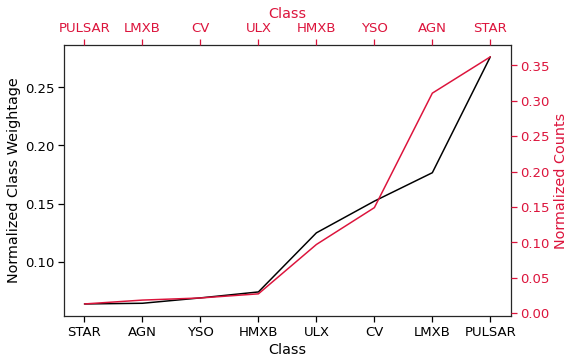

In [52]:
w = calc_weight(0.02 , y)
sns.set(font_scale=1.2, rc={'axes.facecolor':'white', 'figure.facecolor':'white' , 'axes.grid':True} , style="ticks")
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111 , label = 'Weight')
w_sum = sum(w.values())
for wi in w:
    w[wi] = w[wi] / w_sum
ax1.plot(w.keys(), w.values() , color="black")
ax1.set_xlabel("Class", color="black")
ax1.set_ylabel("Normalized Class Weightage", color="black")
ax1.tick_params(axis='x', colors="black")
ax1.tick_params(axis='y', colors="black")


ax2 = fig.add_subplot(111 , label='Value counts' , frame_on=False)
count_dict = y.value_counts().to_dict()
count_total = sum(count_dict.values())
for c in count_dict:
    count_dict[c] = count_dict[c] / count_total
ax2.xaxis.tick_top()
ax2.plot(count_dict.keys() , count_dict.values() , color='crimson')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax2.set_xlabel('Class', color="crimson") 
ax2.set_ylabel('Normalized Counts', color="crimson")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="crimson")
ax2.tick_params(axis='y', colors="crimson")
ax1.grid(False)
ax2.grid(False)
plt.savefig('final_plots/class_weight_balance.jpg')
plt.show()

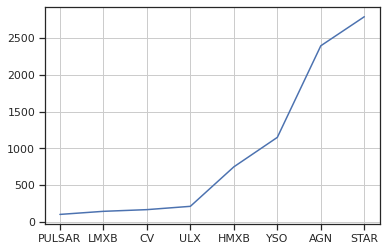

In [77]:
plt.plot(y.value_counts().sort_values().to_dict().keys() , y.value_counts().sort_values().to_dict().values())
plt.show()

In [47]:
gamma_score = {}

In [62]:
def get_res(gamma):
    clf = lgb.LGBMClassifier(n_estimators=50 ,class_weight = calc_weight(gamma) , objective= 'multiclassova', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = -1 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
    from tqdm import tqdm
    res = simple_cv(x,y ,model=clf , k = 15 , normalize_prob=0)
    temp = {}
    temp['score'] = res['class_scores'] 
    temp['pred_table'] = res['res_table']
    return(temp)

In [142]:
import joblib
for gamma in tqdm([0.076 , 0.082 , 0.084 , 0.086 ]):
    gamma_score[gamma] = get_res(gamma) 
    display(gamma_score[gamma]['score'])
    joblib.dump(gamma_score, 'gamma_tune_dict')

  0%|          | 0/4 [00:00<?, ?it/s]

{'STAR': 1.233452569523494, 'AGN': 1.2768826935909376, 'YSO': 1.6646063738015768, 'HMXB': 2.1883119221194036, 'ULX': 15.975829488477357, 'CV': 33.82306131094451, 'LMXB': 60.82494594669641, 'PULSAR': 324.2872281228982}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.930271,0.975482,0.952340
CV,0.608434,0.437229,0.508816
HMXB,0.846257,0.908178,0.876125
LMXB,0.825175,0.880597,0.851986
PULSAR,0.653465,0.229167,0.339332
STAR,0.928315,0.976621,0.951856
ULX,0.748815,0.542955,0.629482
YSO,0.913838,0.932504,0.923077


 25%|██▌       | 1/4 [00:48<02:25, 48.49s/it]

{'STAR': 1.2540542720614913, 'AGN': 1.3017612598977, 'YSO': 1.7329399667064187, 'HMXB': 2.32787660034384, 'ULX': 19.88262339111825, 'CV': 44.662213991169, 'LMXB': 84.12600963298574, 'PULSAR': 511.8717339749572}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.924843,0.977062,0.950236
CV,0.560241,0.404348,0.469697
HMXB,0.847594,0.916185,0.880556
LMXB,0.804196,0.864662,0.833333
PULSAR,0.603960,0.187117,0.285714
STAR,0.922581,0.972422,0.946846
ULX,0.720379,0.510067,0.597250
YSO,0.899913,0.931532,0.915449


 50%|█████     | 2/4 [01:27<01:25, 42.93s/it]

{'STAR': 1.260997690888761, 'AGN': 1.3101613704188086, 'YSO': 1.7563356074868888, 'HMXB': 2.376348860165274, 'ULX': 21.38669994175984, 'CV': 48.998489626383964, 'LMXB': 93.73025718358646, 'PULSAR': 595.9890069748787}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.923173,0.974868,0.948317
CV,0.548193,0.399123,0.461929
HMXB,0.844920,0.914616,0.878388
LMXB,0.811189,0.846715,0.828571
PULSAR,0.603960,0.187117,0.285714
STAR,0.922581,0.974262,0.947717
ULX,0.744076,0.528620,0.618110
YSO,0.905135,0.933573,0.919134


 75%|███████▌  | 3/4 [02:02<00:39, 39.20s/it]

{'STAR': 1.2679795538775671, 'AGN': 1.3186156858536298, 'YSO': 1.780047102260021, 'HMXB': 2.4258304346436144, 'ULX': 23.00455656184641, 'CV': 53.75577632899193, 'LMXB': 104.4309738454125, 'PULSAR': 693.929500026426}
>>> GOING for 1 / 15 Iteration FOLD
>>> GOING for 2 / 15 Iteration FOLD
>>> GOING for 3 / 15 Iteration FOLD
>>> GOING for 4 / 15 Iteration FOLD
>>> GOING for 5 / 15 Iteration FOLD
>>> GOING for 6 / 15 Iteration FOLD
>>> GOING for 7 / 15 Iteration FOLD
>>> GOING for 8 / 15 Iteration FOLD
>>> GOING for 9 / 15 Iteration FOLD
>>> GOING for 10 / 15 Iteration FOLD
>>> GOING for 11 / 15 Iteration FOLD
>>> GOING for 12 / 15 Iteration FOLD
>>> GOING for 13 / 15 Iteration FOLD
>>> GOING for 14 / 15 Iteration FOLD
>>> GOING for 15 / 15 Iteration FOLD


,recall_score,precision_score,f1_score
class,,,
AGN,0.926931,0.975824,0.950749
CV,0.590361,0.403292,0.479218
HMXB,0.823529,0.916667,0.867606
LMXB,0.811189,0.872180,0.840580
PULSAR,0.673267,0.193732,0.300885
STAR,0.917204,0.974115,0.944803
ULX,0.739336,0.528814,0.616601
YSO,0.902524,0.936766,0.919326


100%|██████████| 4/4 [02:35<00:00, 38.91s/it]


In [41]:
import joblib
gamma_score = joblib.load('gamma_tune_dict')
gamma_score.keys()

dict_keys([0.1, 0.005, 0.0, 0.2, 0.05, 0.15, 0.02, 0.04, 0.08, 0.09, 0.012, 0.014, 0.016, 0.018, 0.076, 0.082, 0.084, 0.086])

In [104]:
np.asarray(list(calc_weight(g,y).values()))

array([  1.2679991 ,   1.31863936,   1.77989039,   2.42453326,
        23.09488985,  54.09332758, 102.77821627, 705.55879015])

In [118]:
gdf = pd.DataFrame()
for g in gamma_score.keys():
    gdf.insert(0 , f'{g}' , np.asarray(list(calc_weight(g,y).values())) / np.amax(np.asarray(list(calc_weight(g,y).values())))  )
gdf.insert(0,'counts' , y.value_counts().to_list() / np.amax(y.value_counts().to_list()))
gdf

,counts,0.086,0.084,0.082,0.076,0.018,0.016,0.014,0.012,0.09,0.08,0.04,0.02,0.15,0.05,0.2,0.0,0.005,0.1
0,1.000000,0.001797,0.002082,0.002411,0.003748,0.266304,0.308479,0.357332,0.413922,0.001339,0.002793,0.052852,0.229896,0.000016,0.025341,4.123972e-07,1.0,0.692441,0.000642
1,0.858423,0.001869,0.002163,0.002503,0.003880,0.268496,0.310734,0.359617,0.416190,0.001395,0.002897,0.053824,0.231999,0.000017,0.025925,4.517176e-07,1.0,0.694020,0.000672
2,0.411828,0.002523,0.002899,0.003332,0.005058,0.285893,0.328568,0.377613,0.433979,0.001910,0.003829,0.061882,0.248760,0.000029,0.030864,9.074320e-07,1.0,0.706229,0.000953
3,0.268100,0.003436,0.003921,0.004474,0.006647,0.304999,0.348016,0.397099,0.453105,0.002639,0.005105,0.071449,0.267300,0.000050,0.036940,1.862037e-06,1.0,0.719034,0.001365
4,0.075627,0.032733,0.035442,0.038375,0.048715,0.488858,0.529319,0.573130,0.620566,0.027920,0.041552,0.203842,0.451489,0.002570,0.136968,3.519422e-04,1.0,0.819713,0.018760
5,0.059498,0.076667,0.081386,0.086395,0.103349,0.584180,0.620134,0.658302,0.698818,0.068035,0.091712,0.302841,0.550310,0.011338,0.224656,2.547246e-03,1.0,0.861295,0.050470
6,0.051254,0.145669,0.152344,0.159324,0.182243,0.668176,0.698791,0.730809,0.764294,0.133185,0.166624,0.408196,0.638902,0.034734,0.326277,1.133297e-02,1.0,0.894043,0.106456
7,0.036201,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.000000,1.000000


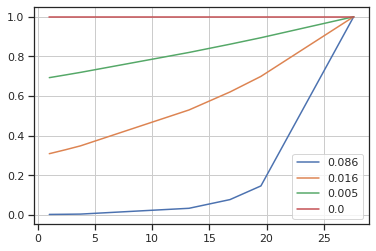

In [133]:
for g in [0.086 , 0.016 , 0.005 , 0.0 ]:
    plt.plot(1/gdf['counts'] , gdf[f'{g}'] , label=f'{g}')
plt.legend()
plt.show()

In [134]:
gdf.corr()['counts'].sort_index()

0.0            NaN
0.005    -0.770684
0.012    -0.737334
0.014    -0.727124
0.016    -0.716654
0.018    -0.705953
0.02     -0.695053
0.04     -0.583403
0.05     -0.532684
0.076    -0.435040
0.08     -0.424340
0.082    -0.419364
0.084    -0.414626
0.086    -0.410117
0.09     -0.401747
0.1      -0.384184
0.15     -0.341020
0.2      -0.329035
counts    1.000000
Name: counts, dtype: float64

In [107]:
gdf = []
for g , v in zip(gamma_score.keys() , gamma_score.values()):
    df_temp = pd.DataFrame({
        'gamma' : g , 
        'class' : v['score'].index.to_list() , 
        'precision' : v['score']['precision_score'].to_list() , 
        'recall' : v['score']['recall_score'].to_list() , 
        'f1' : v['score']['f1_score'].to_list() , 
    })
    gdf.append(df_temp)
gdf = pd.concat(gdf).reset_index(drop=True)
gdf

,gamma,class,precision,recall,f1
0,0.100,AGN,0.973909,0.903967,0.937635
1,0.100,CV,0.367257,0.500000,0.423469
2,0.100,HMXB,0.860563,0.816845,0.838134
3,0.100,LMXB,0.874074,0.825175,0.848921
4,0.100,PULSAR,0.171355,0.663366,0.272358
...,...,...,...,...,...
139,0.086,LMXB,0.872180,0.811189,0.840580
140,0.086,PULSAR,0.193732,0.673267,0.300885
141,0.086,STAR,0.974115,0.917204,0.944803
142,0.086,ULX,0.528814,0.739336,0.616601


Mathew's correlation coefficient

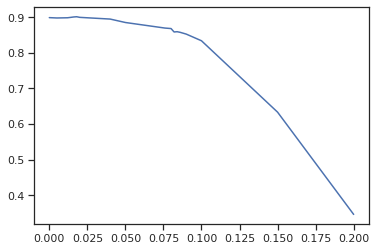

In [108]:
# MCC coefficient
#gamma_score[0.1]['pred_table']
mcc = []
from sklearn.metrics import matthews_corrcoef
for g in gamma_score.keys():
    pred_table = gamma_score[g]['pred_table']
    mcc.append(matthews_corrcoef(pred_table['true_class'] , pred_table['pred_class']))
mcc_df = pd.DataFrame({
    'gamma' : gamma_score.keys() , 
    'mcc' : mcc
}).sort_values(by = 'gamma').reset_index(drop=True)
plt.plot(mcc_df['gamma'] , mcc_df['mcc'])
plt.grid()
plt.show()

In [109]:
mcc_df

,gamma,mcc
0,0.000,0.898815
1,0.005,0.897854
2,0.012,0.898436
3,0.014,0.899490
4,0.016,0.900639
5,0.018,0.901305
6,0.020,0.899591
7,0.040,0.894772
8,0.050,0.885134
9,0.076,0.869498


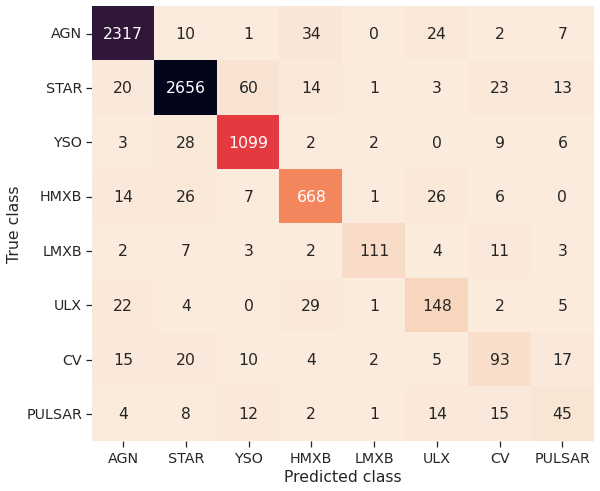

In [76]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.3 , 
    'cbar' : False ,
    'plot_num' : False,
}
fig , ax = plt.subplots(nrows=1, ncols=1 , figsize=(9,8))
plot_cf([gamma_score[0.016]['pred_table']] , normalize = None , plot_dict=plot_dict_def , ax=ax)
plt.savefig('final_plots/confusion_mat_lightGBM.jpg')

In [83]:
gamma_score[0.016]['pred_table']

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J180921.9-232753,STAR,YSO,0.978112,0.004509,0.000195,0.002041,0.000557,0.000140,0.068583,0.000356,0.978112
2CXO J110653.3+035010,AGN,AGN,0.994428,0.994428,0.000404,0.001019,0.008244,0.000567,0.003650,0.000386,0.001102
2CXO J053516.3-052248,STAR,STAR,0.980531,0.013289,0.020162,0.003478,0.004082,0.000190,0.980531,0.018904,0.001084
2CXO J044223.1+020219,AGN,ULX,0.295438,0.282524,0.049316,0.095273,0.006625,0.006864,0.009204,0.295438,0.000883
2CXO J105144.2+353930,AGN,AGN,0.994052,0.994052,0.000724,0.002258,0.000516,0.000155,0.006037,0.000733,0.001559
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J010506.4-061509,AGN,ULX,0.986267,0.292611,0.005668,0.147303,0.000409,0.557990,0.011708,0.986267,0.000979
2CXO J053509.6-052623,STAR,STAR,0.992282,0.002861,0.001239,0.004343,0.000568,0.000141,0.992282,0.000288,0.002785
2CXO J213556.6+572052,STAR,STAR,0.990152,0.009036,0.001972,0.002392,0.000330,0.000454,0.990152,0.000153,0.000992


In [87]:
from utilities import get_score
get_score([gamma_score[0.086]['pred_table']] , sc_average='macro')

{'classes': array(['AGN', 'CV', 'HMXB', 'LMXB', 'PULSAR', 'STAR', 'ULX', 'YSO'],
       dtype=object),
 'num_src':         pred_class
 STAR          2627
 AGN           2275
 YSO           1107
 HMXB           672
 PULSAR         351
 ULX            295
 CV             243
 LMXB           133,
 'balanced_accuracy': 0.7980428537203661,
 'accuracy': 0.891860314163313,
 'precision': 0.7251737777625389,
 'recall': 0.7980428537203661,
 'f1': 0.7399709745803331,
 'mcc': 0.8575232747446131,
 'class_scores':         recall_score  precision_score  f1_score
 class                                          
 AGN         0.926931         0.975824  0.950749
 CV          0.590361         0.403292  0.479218
 HMXB        0.823529         0.916667  0.867606
 LMXB        0.811189         0.872180  0.840580
 PULSAR      0.673267         0.193732  0.300885
 STAR        0.917204         0.974115  0.944803
 ULX         0.739336         0.528814  0.616601
 YSO         0.902524         0.936766  0.919326}

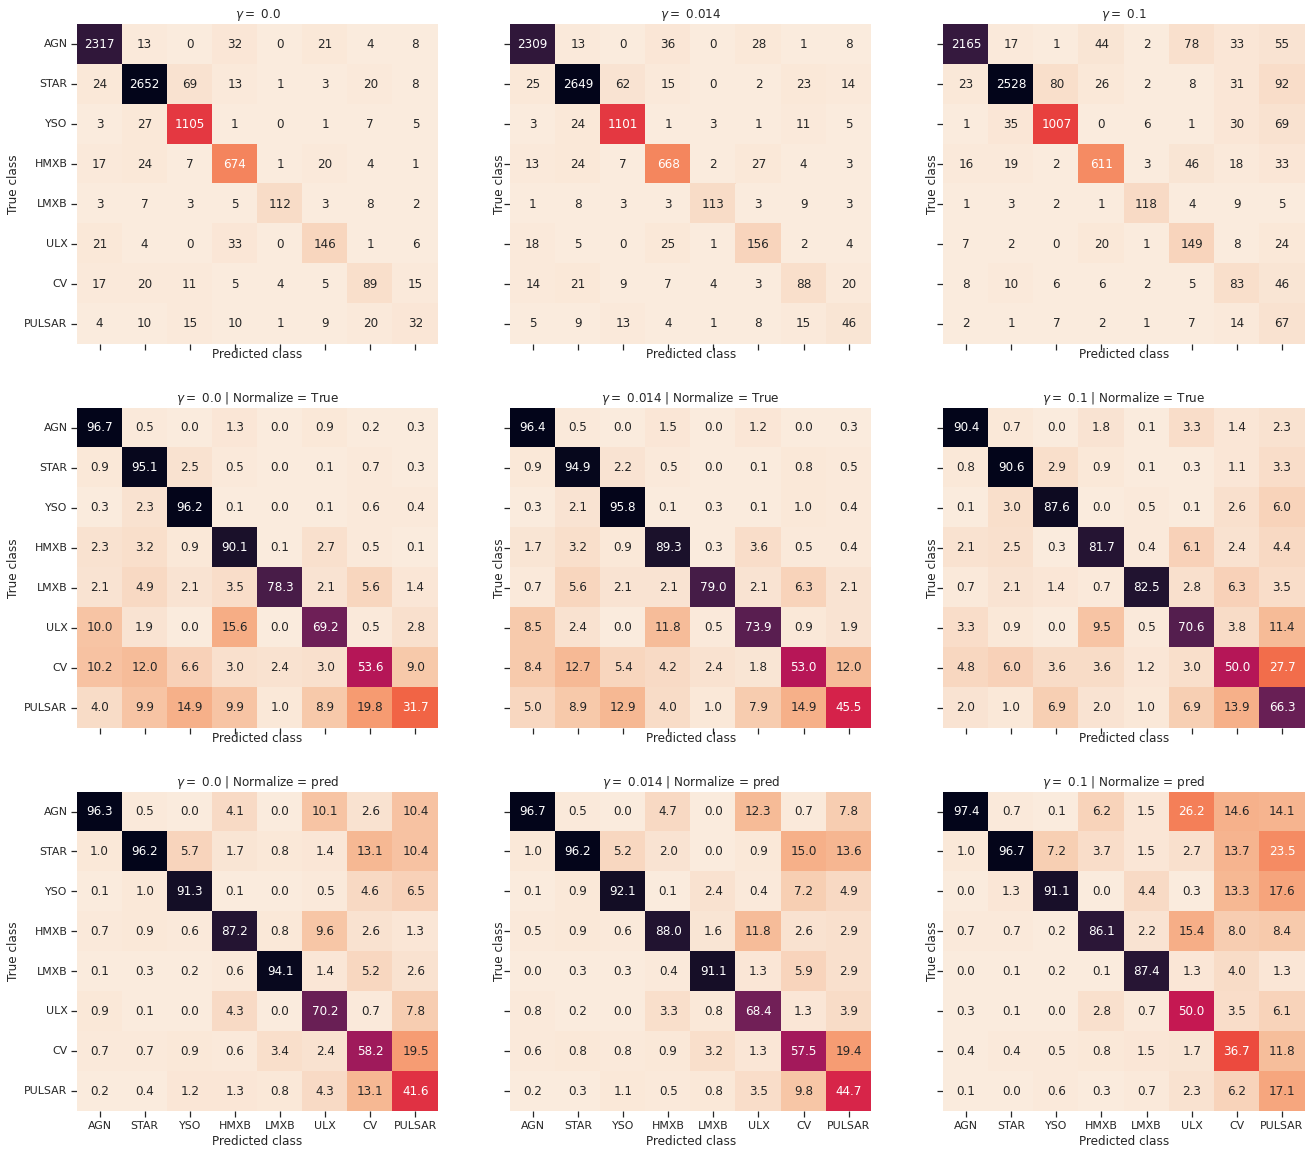

In [115]:
#g = 0.016
from utilities import plot_cf 
fig , ax = plt.subplots(nrows= 3 , ncols=3 , figsize=(22,20) , sharey=True , sharex=True)
g = [0.000 , 0.014 , 0.100]
for i in range(len(g)):
    plot_cf([gamma_score[g[i]]['pred_table']] , normalize = None , ax=ax[0][i])
    ax[0][i].set_title(f'$\gamma = $ {g[i]}')
    plot_cf([gamma_score[g[i]]['pred_table']] , normalize = 'true' , ax=ax[1][i])
    ax[1][i].set_title(f'$\gamma = $ {g[i]} | Normalize = True')
    plot_cf([gamma_score[g[i]]['pred_table']] , normalize = 'pred' , ax=ax[2][i])
    ax[2][i].set_title(f'$\gamma = $ {g[i]} | Normalize = pred')
plt.show()

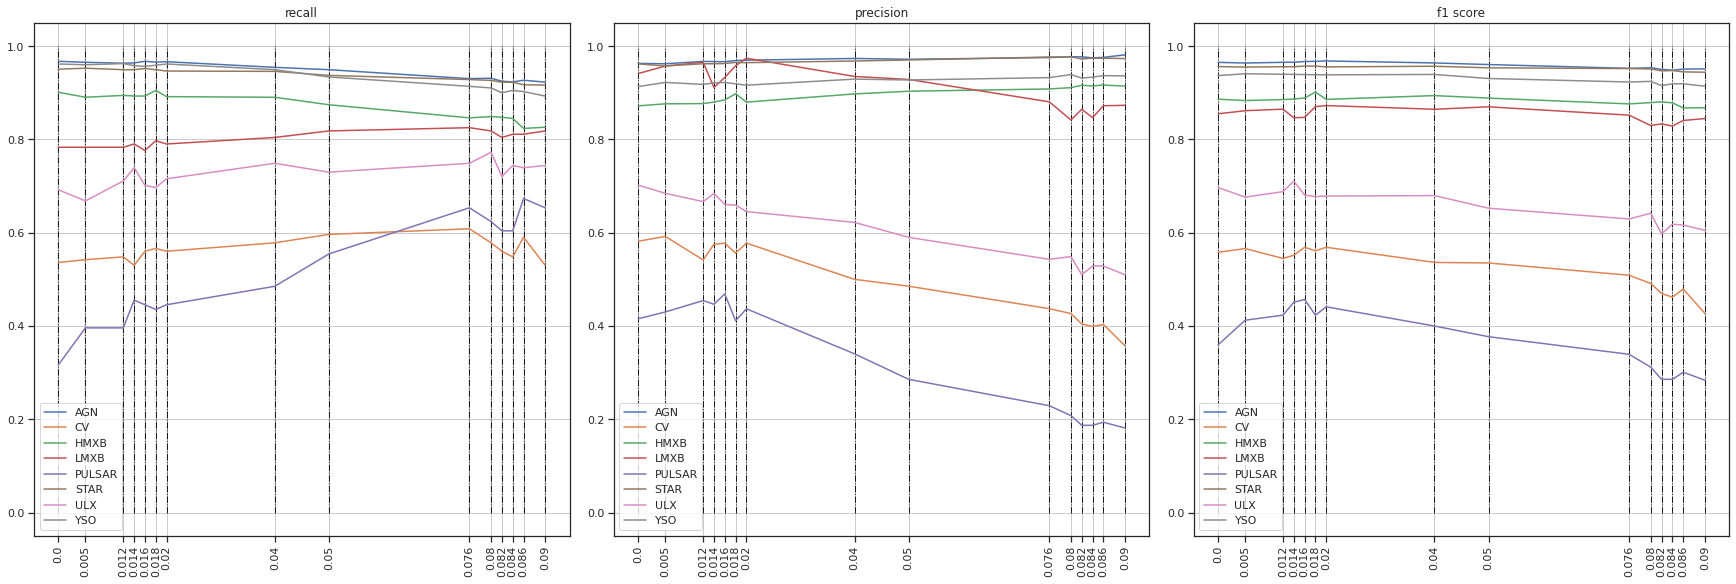

In [112]:
fig , ax = plt.subplots(nrows=1 , ncols=3 ,  figsize=(24,8) ,  constrained_layout=True)
for cl in np.unique(gdf['class']):
    temp = gdf[gdf['class']==cl].sort_values(by='gamma')
    temp = temp[temp['gamma']<0.1]
    ax[0].plot(temp['gamma'] , temp['recall'] , label=cl)
    ax[0].vlines(temp['gamma'] , ymin = 0 , ymax=1 , linewidth=0.1 , color='k' , alpha=0.2 , linestyle='-.')
    ax[0].set_title('recall')
    ax[1].plot(temp['gamma'] , temp['precision'] , label=cl)
    ax[1].set_title('precision')
    ax[2].plot(temp['gamma'] , temp['f1'] , label=cl)
    ax[2].set_title('f1 score')
    plt.legend()
    #plt.xlim(0 , 0.15)
for a in ax:
    #a.grid()
    a.set_xticks(temp['gamma'] , )
    a.set_xticklabels(temp['gamma'], rotation=90)
    a.vlines(temp['gamma'] , ymin = 0 , ymax=1 , linewidth=1 , color='k' , alpha=1, linestyle='-.')
    a.legend()
plt.show()

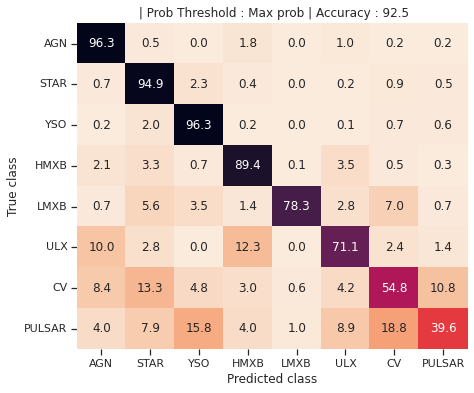

In [113]:
plot_cf([gamma_score[0.012]['pred_table']] , normalize='true' , )


#### Score analysis

In [72]:
score_df_ova2 = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova2.to_csv('temp_res_comp/scores/LightGBM-ovaclass-w-0.09-without-gal-coord.csv')

In [18]:
score_df_ova = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova.to_csv('temp_res_comp/scores/LightGBM_ovaclass_w-0.05.csv')

In [ ]:
#score_df = pd.concat([el['class_scores'] for el in res_arr]).reset_index().sort_values(by='recall_score')
#score_df.to_csv('temp_res_comp/scores/LightGBM_allclass.csv')
score_df= pd.read_csv('temp_res_comp/scores/LightGBM-allclass.csv')
score_df

,Unnamed: 0,class,recall_score,precision_score,f1_score
0,12,PULSAR,0.45,0.38,0.41
1,52,PULSAR,0.45,0.37,0.40
2,20,PULSAR,0.46,0.37,0.41
3,28,PULSAR,0.47,0.39,0.43
4,60,PULSAR,0.48,0.38,0.42
...,...,...,...,...,...
75,56,AGN,0.97,0.97,0.97
76,0,AGN,0.97,0.97,0.97
77,64,AGN,0.97,0.97,0.97
78,40,AGN,0.97,0.97,0.97


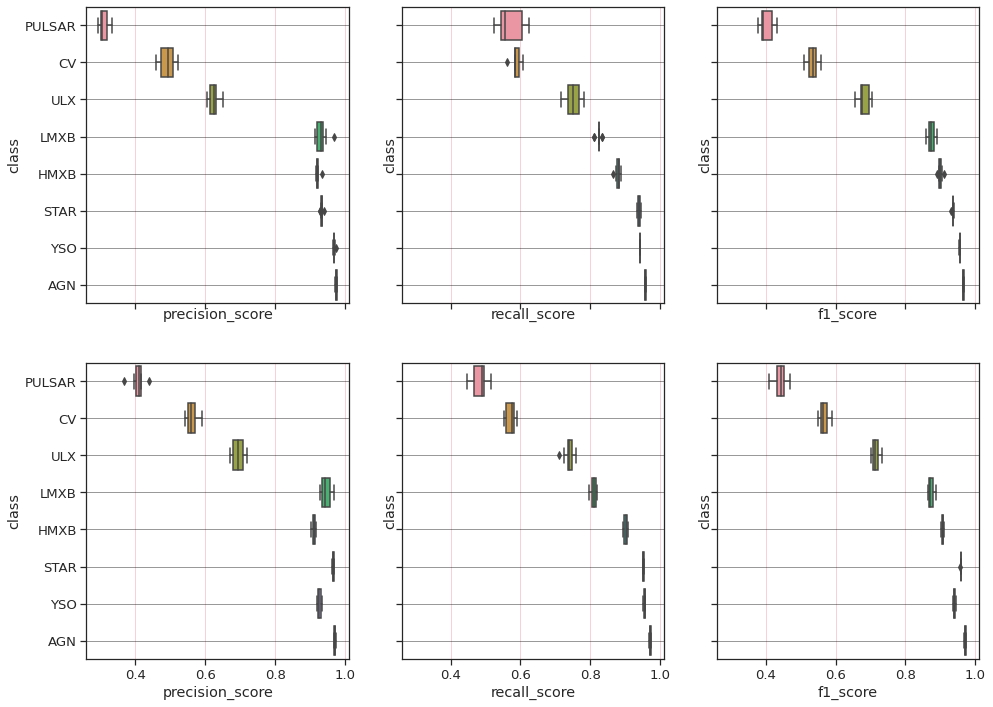

In [ ]:
fig , ax = plt.subplots(nrows=2 , ncols=3 , sharey=True ,sharex=True ,  figsize= (16,12))
sns.set_palette('vlag')
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'precision_score' , ax=ax[0][0])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'recall_score' , ax=ax[0][1])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'f1_score' , ax=ax[0][2])

sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'precision_score' , ax=ax[1][0])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'recall_score' , ax=ax[1][1])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'f1_score' , ax=ax[1][2])
for ai in ax:
    for a in ai:
        a.yaxis.grid(True, color ="black" , alpha=0.4)
        a.xaxis.grid(True , color='crimson' , alpha=0.2)
#plt.savefig()
plt.show()

In [19]:
res['res_table']

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J183122.4-621642,STAR,STAR,0.999893,0.000011,3.115960e-06,0.000802,0.000013,0.000009,0.999893,0.000002,0.000002
2CXO J091432.7+561238,STAR,STAR,0.999436,0.001137,5.217488e-07,0.000114,0.000004,0.000004,0.999436,0.000002,0.000002
2CXO J213701.3+572446,STAR,STAR,0.996884,0.000021,3.568341e-04,0.000049,0.000004,0.000227,0.996884,0.000125,0.000003
2CXO J180935.6-255553,STAR,STAR,0.999765,0.000003,1.891440e-05,0.000006,0.000025,0.000008,0.999765,0.000002,0.000005
2CXO J100038.3+013708,AGN,AGN,0.583731,0.583731,9.758183e-05,0.000011,0.000228,0.000112,0.000081,0.001313,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J133952.0-313859,HMXB,HMXB,0.999359,0.000735,7.761753e-03,0.999359,0.000009,0.028662,0.000427,0.000030,0.000002
2CXO J180223.5-230023,YSO,YSO,0.999825,0.000030,1.412598e-04,0.000011,0.000075,0.000257,0.002982,0.000016,0.999825
2CXO J022233.4+422026,ULX,CV,0.540499,0.000121,5.404986e-01,0.039702,0.009500,0.000002,0.001100,0.004956,0.000003


In [21]:
clf = res['clf']

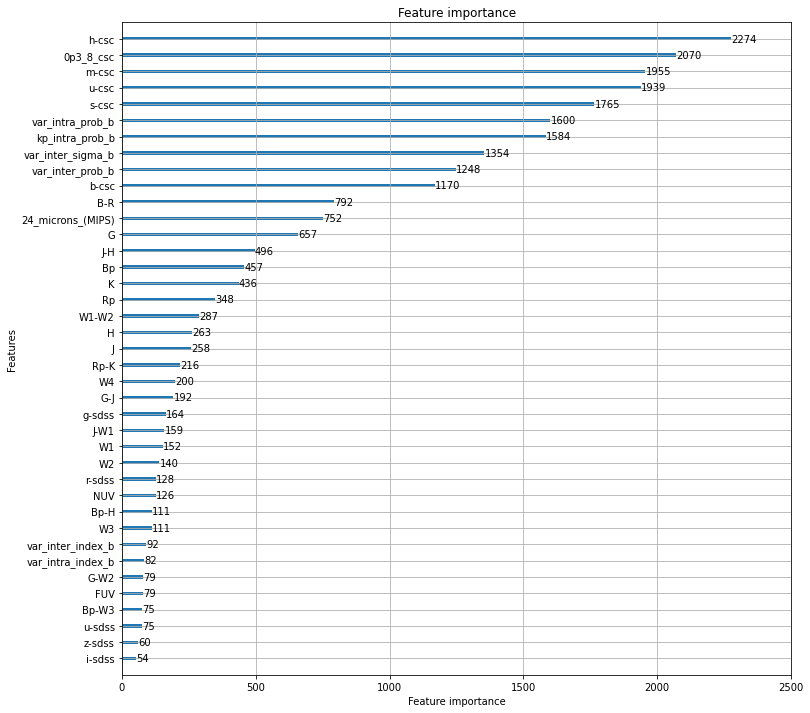

In [73]:
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(12,12))
lgb.plot_importance(clf , ax=ax)
plt.show()

In [74]:
import joblib

# save model
joblib.dump(clf, 'models/lgb-ova-no-gal.pkl')


['models/lgb-ova-no-gal.pkl']

In [75]:
pd.options.display.float_format = '{:,.2f}'.format
class_scores = res['class_scores']
print(class_scores.to_markdown())

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.901879 |          0.957447 |   0.928833 |
| CV      |       0.415663 |          0.285124 |   0.338235 |
| HMXB    |       0.574866 |          0.659509 |   0.614286 |
| LMXB    |       0.58042  |          0.419192 |   0.486804 |
| PULSAR  |       0.425743 |          0.177686 |   0.250729 |
| STAR    |       0.88853  |          0.935825 |   0.911565 |
| ULX     |       0.578199 |          0.398693 |   0.471954 |
| YSO     |       0.830287 |          0.823834 |   0.827048 |


Text(0.5, 1.0, 'CF for LighgGBM,')

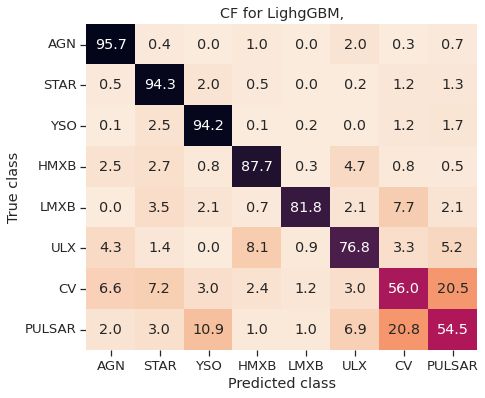

In [46]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 ,
    'cbar' : False ,
    'plot_num' : 0,
}
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(7,6))
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0. , ax=ax)
plt.title('CF for LighgGBM,')
#plt.savefig('temp_res_comp/cf/lightGBM_rf.png')

In [54]:
res['res_table'].to_csv('temp_res_comp/train_prob/lightGBM_none.csv')

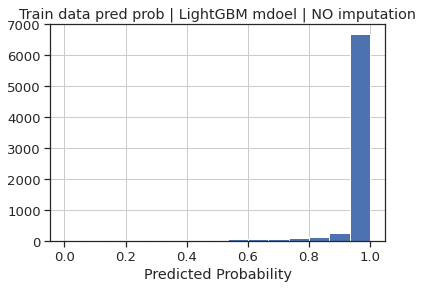

In [48]:
plt.hist(res['res_table']['pred_prob'] , bins=15)
plt.title('Train data pred prob | LightGBM mdoel | NO imputation')
plt.xlabel('Predicted Probability')
plt.savefig('temp_res_comp/train_prob_dist/LightGBM_prob.jpg')
plt.show()

## Prediction on New sources

In [152]:
# load model
import joblib
mdoel = joblib.load('models/lightGBM-ova.pkl')
clf = model.clf

In [175]:
u = []
ui = []
for i in range(8):
    u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
    ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
u = pd.concat(u)
ui = pd.concat(ui)
ui = pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name')
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
u

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J004829.5-732959,2.560959,8.422809,NaN,NaN,2.363359,NaN,9.949403,0.0,3.304254e-09,0.002147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J005449.0-725128,2.525176,8.405124,NaN,NaN,0.900227,NaN,1.221561,0.0,4.201018e-07,0.011944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010049.1-731526,2.548291,8.388764,NaN,NaN,2.694112,NaN,4.333967,0.0,8.611031e-08,0.003832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010049.8-731045,2.543942,8.388578,NaN,NaN,3.098912,NaN,3.680766,0.0,1.742587e-06,0.009243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J010647.7-730940,2.544536,8.371916,NaN,NaN,9.693387,NaN,9.994160,6.0,5.241312e-08,0.003135,...,7.329417,3.418280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,2.153631,9.602391,6.284069,0.008090,0.848783,5.00,9.398184,0.0,2.267642e-07,0.035677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220508.3-495935,2.148799,9.600738,7.232708,0.007515,7.897757,6.25,9.373067,2.0,8.028243e-08,0.041673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J220544.0-495505,2.142337,9.602388,7.905990,0.007822,NaN,6.25,NaN,NaN,1.863801e-07,0.016260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J004829.5-732959,0.034298,0.036080,0.732763,0.000045,0.029809,0.812257,0.002581,0.000045
2CXO J005449.0-725128,0.197113,0.033539,0.810988,0.000002,0.000740,0.205842,0.000102,0.000131
2CXO J010049.1-731526,0.080060,0.028754,0.747214,0.000025,0.034703,0.578318,0.002800,0.000075
2CXO J010049.8-731045,0.170131,0.041141,0.222394,0.000071,0.004165,0.617904,0.000309,0.000167
2CXO J010647.7-730940,0.009535,0.117541,0.725933,0.004263,0.057545,0.377006,0.000015,0.000076
...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,0.086030,0.324645,0.600063,0.000006,0.000044,0.010773,0.001505,0.000296
2CXO J220508.3-495935,0.047244,0.359949,0.635139,0.000075,0.003004,0.006719,0.002030,0.000205
2CXO J220544.0-495505,0.016525,0.049217,0.683977,0.000006,0.000005,0.016902,0.000152,0.000344
2CXO J220555.6-500837,0.005744,0.027714,0.760570,0.000052,0.002039,0.001890,0.500417,0.000108


In [177]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,STAR,0.812257,0.079494,0.034298,0.036080,0.732763,0.000045,0.029809,0.812257,0.002581,0.000045
2CXO J005449.0-725128,HMXB,0.810988,0.605146,0.197113,0.033539,0.810988,0.000002,0.000740,0.205842,0.000102,0.000131
2CXO J010049.1-731526,HMXB,0.747214,0.168896,0.080060,0.028754,0.747214,0.000025,0.034703,0.578318,0.002800,0.000075
2CXO J010049.8-731045,STAR,0.617904,0.395510,0.170131,0.041141,0.222394,0.000071,0.004165,0.617904,0.000309,0.000167
2CXO J010647.7-730940,HMXB,0.725933,0.348927,0.009535,0.117541,0.725933,0.004263,0.057545,0.377006,0.000015,0.000076
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.600063,0.275418,0.086030,0.324645,0.600063,0.000006,0.000044,0.010773,0.001505,0.000296
2CXO J220508.3-495935,HMXB,0.635139,0.275190,0.047244,0.359949,0.635139,0.000075,0.003004,0.006719,0.002030,0.000205
2CXO J220544.0-495505,HMXB,0.683977,0.634760,0.016525,0.049217,0.683977,0.000006,0.000005,0.016902,0.000152,0.000344


In [170]:
#u_df.to_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv')

In [178]:
#u_df = pd.read_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J004829.5-732959,STAR,0.812257,0.079494,0.034298,0.036080,0.732763,0.000045,0.029809,0.812257,0.002581,0.000045
2CXO J005449.0-725128,HMXB,0.810988,0.605146,0.197113,0.033539,0.810988,0.000002,0.000740,0.205842,0.000102,0.000131
2CXO J010049.1-731526,HMXB,0.747214,0.168896,0.080060,0.028754,0.747214,0.000025,0.034703,0.578318,0.002800,0.000075
2CXO J010049.8-731045,STAR,0.617904,0.395510,0.170131,0.041141,0.222394,0.000071,0.004165,0.617904,0.000309,0.000167
2CXO J010647.7-730940,HMXB,0.725933,0.348927,0.009535,0.117541,0.725933,0.004263,0.057545,0.377006,0.000015,0.000076
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.600063,0.275418,0.086030,0.324645,0.600063,0.000006,0.000044,0.010773,0.001505,0.000296
2CXO J220508.3-495935,HMXB,0.635139,0.275190,0.047244,0.359949,0.635139,0.000075,0.003004,0.006719,0.002030,0.000205
2CXO J220544.0-495505,HMXB,0.683977,0.634760,0.016525,0.049217,0.683977,0.000006,0.000005,0.016902,0.000152,0.000344


In [179]:
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True)
u_pos

,class,prob,ra,dec
name,,,,
2CXO J004829.5-732959,STAR,0.812257,12.123114,-73.499901
2CXO J005449.0-725128,HMXB,0.810988,13.704345,-72.857987
2CXO J010049.1-731526,HMXB,0.747214,15.204787,-73.257463
2CXO J010049.8-731045,STAR,0.617904,15.207831,-73.179381
2CXO J010647.7-730940,HMXB,0.725933,16.699164,-73.161175
...,...,...,...,...
2CXO J220433.1-495916,HMXB,0.600063,331.138121,-49.987838
2CXO J220508.3-495935,HMXB,0.635139,331.284642,-49.993301
2CXO J220544.0-495505,HMXB,0.683977,331.433541,-49.918280


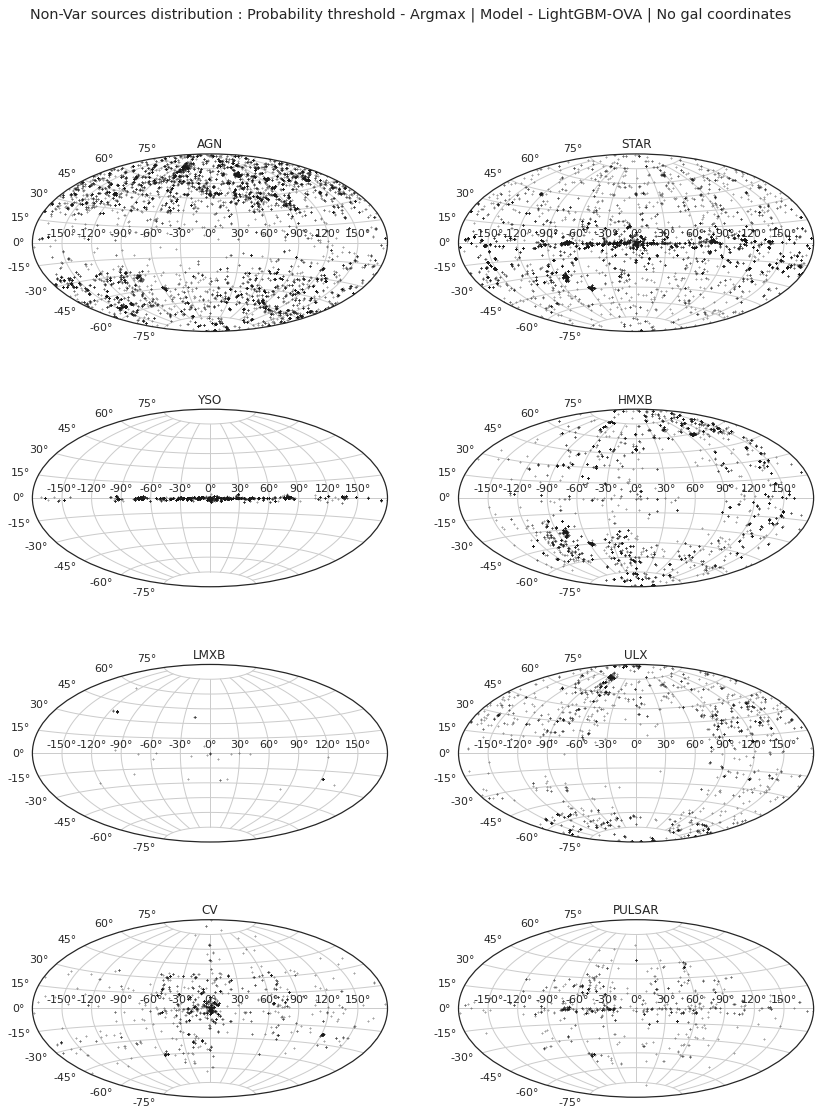

In [180]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
#plt.savefig('plots/all_src_pred/lightgbm_non-var.jpg')
plt.show()

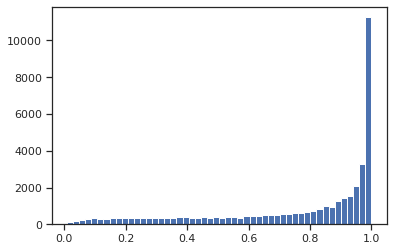

0.980135950990046

In [181]:
x ,y ,z = plt.hist(u_df['prob'] ,bins=50)
plt.grid()
plt.show()
mode = y[np.argmax(x)]
mode

In [182]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                u_df[u_df['prob']>0.6]['class'].value_counts(),
                u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                u_df[u_df['prob']>0.9]['class'].value_counts(),
                u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax' , f"Most probable > {mode :.2f}" ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'0.98']
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   Most probable > 0.98 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |   0.98 |
|:--------|---------:|-----------------------:|------:|------:|------:|------:|------:|-------:|
| STAR    |    10629 |                   4121 |  8774 |  8290 |  7736 |  7032 |  5958 |   4130 |
| AGN     |    10578 |                   2819 |  8235 |  7736 |  7112 |  6286 |  5008 |   2827 |
| YSO     |     9266 |                   3176 |  8709 |  8445 |  8066 |  7420 |  6050 |   3190 |
| HMXB    |     4606 |                    671 |  2907 |  2578 |  2212 |  1816 |  1327 |    673 |
| ULX     |     2161 |                    200 |  1506 |  1317 |  1099 |   868 |   585 |    201 |
| CV      |     1631 |                    104 |   959 |   816 |   670 |   528 |   322 |    104 |
| PULSAR  |      858 |                     46 |   544 |   478 |   402 |   307 |   189 |     46 |
| LMXB    |      164 |                    124 |   140 |   139 |   136 |   132 |   132 |    124 |


In [183]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
#cl.remove('LMXB')
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

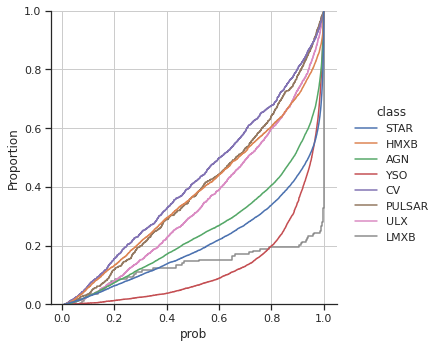

In [184]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()